In [1]:
# %matplotlib notebook
# %matplotlib ipympl


# Passive Hopper(Ground)

In [8]:
import os
# Get current working directory
cwd = os.getcwd()

# Only go up one level if we’re currently inside 'notebooks'
if cwd.endswith("notebooks"):
    os.chdir("..")
print("Current working directory:", os.getcwd())

Current working directory: /home/jerry-razer/hopper_sim


In [9]:
import yaml

with open("cfg/simple_passive_hopper.yaml", "r") as f:
    cfg = yaml.safe_load(f)

m_b = cfg["body_mass"]
m_l = cfg["leg_mass"]
l0 = cfg["spring_length"]
k = cfg["spring_constant"]
g = cfg["gravity"]
x0 = cfg["x0"]

In [10]:
print(f"Body mass: {m_b}, Leg mass: {m_l}, Spring length: {l0}, Spring constant: {k}, Gravity: {g}, Initial state: {x0}")

Body mass: 1, Leg mass: 0.2, Spring length: 0.3, Spring constant: 100, Gravity: 9.81, Initial state: [0.5, -0.1, 0.4, 0.0]


## One States State Machine (Stance)

Set Leg Position to Ground(0) for Stance State Simulation


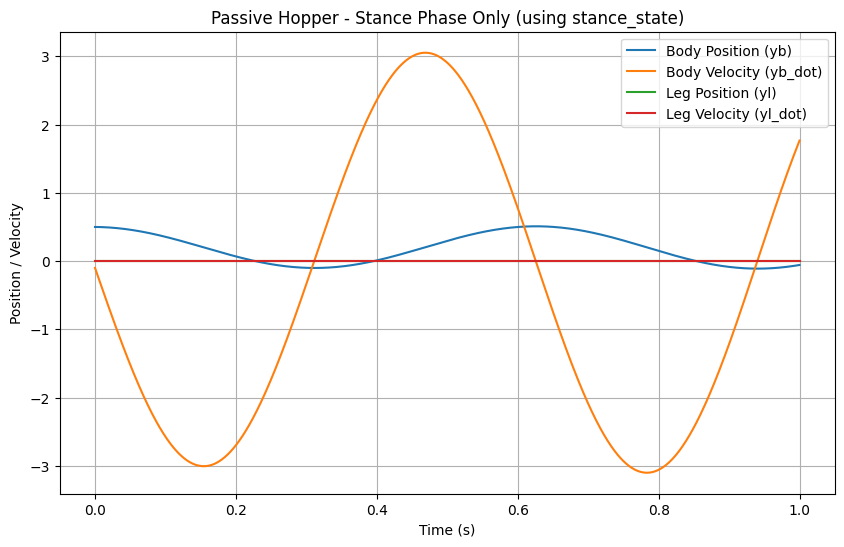

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from models.simple_passive_hopper import stance_state

# --- Simulation parameters ---
dt = 0.001
t_max = 1.0
steps = int(t_max / dt)
t = np.linspace(0, t_max, steps)

# --- Initial state ---
x = np.zeros((steps, 4))
x[0] = x0  # [x_b, x_b_dot, x_l, x_l_dot]
if x[0,2] != 0:
    x[0, 2] = 0
    print("Set Leg Position to Ground(0) for Stance State Simulation")

# --- Simulation loop ---
for i in range(1, steps):
    x_dot, _ = stance_state(x[i-1], k, l0, m_b, m_l, g)
    x[i] = x[i-1] + x_dot * dt

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(t, x[:, 0], label="Body Position (yb)")
plt.plot(t, x[:, 1], label="Body Velocity (yb_dot)")
plt.plot(t, x[:, 2], label="Leg Position (yl)")
plt.plot(t, x[:, 3], label="Leg Velocity (yl_dot)")
plt.xlabel("Time (s)")
plt.ylabel("Position / Velocity")
plt.title("Passive Hopper - Stance Phase Only (using stance_state)")
plt.legend()
plt.grid(True)
plt.show()


## Two States State Machine

Initial state: flight


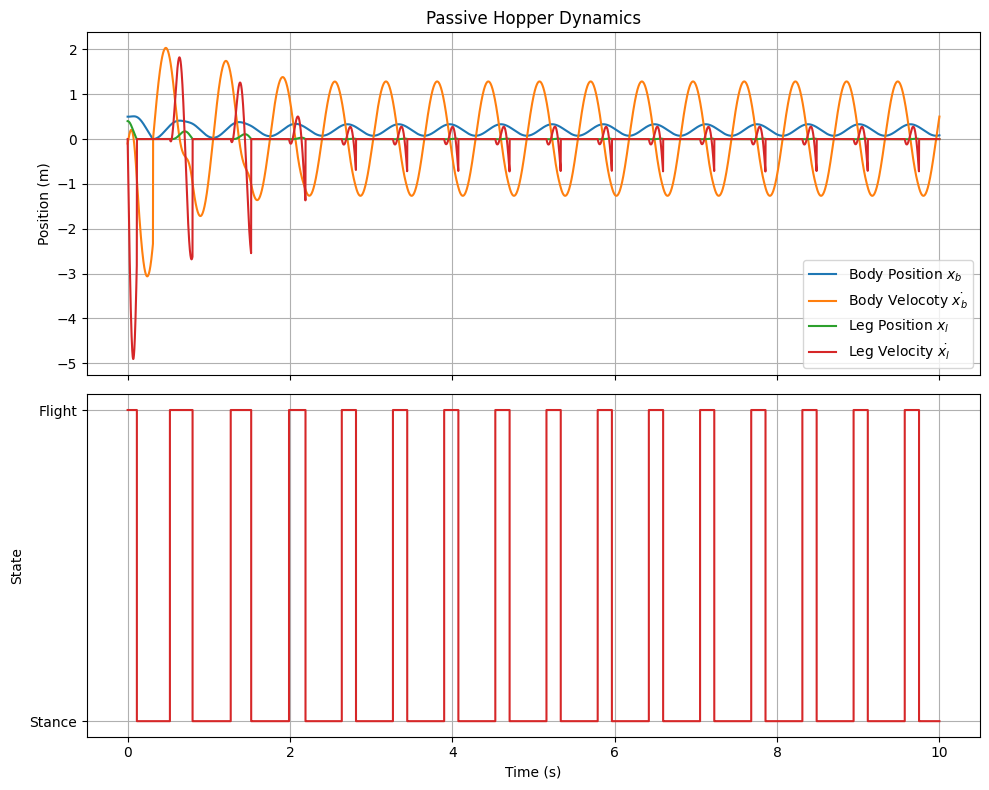

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from models.simple_passive_hopper import flight_state, stance_state

# --- Simulation ---
dt = 0.001
t_max = 10.0
steps = int(t_max / dt)
t = np.linspace(0, t_max, steps)

# initial state
x = np.zeros((steps, 4))
x[0] = x0

if x0[2] > 0:
    state = "flight"
else:
    state = "stance"

print(f"Initial state: {state}")
# Store state (0 = stance, 1 = flight)
state_arr = np.zeros(steps)
state_arr[0] = 1 if state == "flight" else 0

for i in range(1, steps):
    if state == "flight":
        x_dot = flight_state(x[i-1], k, l0, m_b, m_l, g)
        x[i] = x[i-1] + x_dot * dt

        # touchdown (leg reaches ground while moving downward)
        if x[i-1][2] > 0 and x[i][2] <= 0 and x[i-1][3] < 0:
            x[i][2] = 0
            x[i][3] = 0
            state = "stance"


    elif state == "stance":
        x_dot, F_Spring_prev = stance_state(x[i-1], k, l0, m_b, m_l, g)
        x[i] = x[i-1] + x_dot * dt
        F_spring = k * (l0 - (x[i][0] - x[i][2]))

        # --- Enforce ground constraint for body ---
        if x[i][0] < 0:
            x[i][0] = 0
            if x[i][1] < 0:
                x[i][1] = 0  # stop downward velocity (no penetration)

        # --- Lift-off detection ---
        if F_Spring_prev > 0 and F_spring <= 0 and x[i][1] > 0:
            state = "flight"

    
    state_arr[i] = 1 if state == "flight" else 0


# --- Plotting ---
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Trajectories
axs[0].plot(t, x[:, 0], label='Body Position $x_b$')
axs[0].plot(t, x[:, 1], label='Body Velocoty $\dot{x_b}$')
axs[0].plot(t, x[:, 2], label='Leg Position $x_l$')
axs[0].plot(t, x[:, 3], label='Leg Velocity $\dot{x_l}$')
axs[0].set_ylabel('Position (m)')
axs[0].set_title('Passive Hopper Dynamics')
axs[0].legend()
axs[0].grid(True)

# State transitions (flight = 1, stance = 0)
axs[1].plot(t, state_arr, color='tab:red', drawstyle='steps-post')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('State')
axs[1].set_yticks([0, 1])
axs[1].set_yticklabels(['Stance', 'Flight'])
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Visualize in PyPlot

In [7]:
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# import numpy as np

# fig, ax = plt.subplots(figsize=(6, 6))
# ax.set_xlim(-0.2, 0.2)
# ax.set_ylim(-0.1, np.max(x[:,0]) + 0.2)
# ax.set_xlabel("Horizontal position (m)")
# ax.set_ylabel("Height (m)")
# ax.set_title("2D Passive Hopper Animation")

# body_dot, = ax.plot([], [], 'bo', markersize=10, label='Body')
# leg_dot,  = ax.plot([], [], 'ro', markersize=6, label='Leg')
# spring_ln, = ax.plot([], [], 'g-', linewidth=3, label='Spring')
# ax.legend()
# ax.grid(True)

# def init():
#     body_dot.set_data([], [])
#     leg_dot.set_data([], [])
#     spring_ln.set_data([], [])
#     return body_dot, leg_dot, spring_ln

# def update(i):
#     z_body = x[i,0]
#     z_leg  = x[i,2]
#     in_flight = state_arr[i] > 0.5
#     if not in_flight:
#         z_leg = 0
#         spring_ln.set_data([0,0], [z_leg, z_body])
#     else:
#         spring_ln.set_data([], [])
#     body_dot.set_data([0], [z_body])
#     leg_dot.set_data([0], [z_leg])
#     return body_dot, leg_dot, spring_ln

# ani = animation.FuncAnimation(fig, update, frames=len(t),
#                               init_func=init, blit=True,
#                               interval=max(dt*1000,10), repeat=True)
# plt.show()


### Visualize in Pybullet

In [ ]:
import pybullet as p
import pybullet_data
import time
import numpy as np

# Assumes x, t, state_arr, dt are already defined from your simulation
# x[:,0] = body pos, x[:,2] = leg pos, state_arr ∈ {0 (stance), 1 (flight)}

p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0, 0, -9.81)

# Slightly lower plane so body never visually penetrates
plane = p.loadURDF("plane.urdf", [0, 0, -0.02])

# --- Visual parameters ---
h_body = 0.05   # half height of body
h_leg  = 0.025  # half height of leg (smaller)
spring_color = [0, 1, 0]  # green

# --- Create shapes ---
body_visual = p.createVisualShape(p.GEOM_BOX, halfExtents=[h_body, h_body, h_body], rgbaColor=[0, 0, 1, 1])
leg_visual  = p.createVisualShape(p.GEOM_BOX, halfExtents=[h_leg,  h_leg,  h_leg],  rgbaColor=[1, 0.5, 0, 1])
body_col    = p.createCollisionShape(p.GEOM_BOX, halfExtents=[h_body, h_body, h_body])
leg_col     = p.createCollisionShape(p.GEOM_BOX, halfExtents=[h_leg,  h_leg,  h_leg])

# --- Create rigid bodies (visual only) ---
body = p.createMultiBody(baseMass=1,
                         baseCollisionShapeIndex=body_col,
                         baseVisualShapeIndex=body_visual,
                         basePosition=[0, 0, x[0, 0] + h_body])

leg = p.createMultiBody(baseMass=1,
                        baseCollisionShapeIndex=leg_col,
                        baseVisualShapeIndex=leg_visual,
                        basePosition=[0, 0, x[0, 2] + h_leg])

# --- Animation loop ---
try:
    while True:
        start_time = time.time()
        for i in range(len(t)):
            # --- Get states ---
            z_body = x[i, 0]
            z_leg  = x[i, 2]
            in_flight = state_arr[i] > 0.5

            # --- Ground lock: leg stays at z=0 during stance ---
            if not in_flight:
                z_leg = 0.0

            # --- Set new visual positions ---
            p.resetBasePositionAndOrientation(body, [0, 0, z_body + h_body], [0, 0, 0, 1])
            p.resetBasePositionAndOrientation(leg, [0, 0, z_leg + h_leg], [0, 0, 0, 1])

            # --- Draw spring (only in stance) ---
            p.removeAllUserDebugItems()
            if not in_flight:
                p.addUserDebugLine(
                    [0, 0, z_leg + h_leg],
                    [0, 0, z_body + h_body],
                    spring_color, 2, dt
                )

            # --- Real-time sync ---
            target_time = start_time + t[i]
            sleep_time = target_time - time.time()
            if sleep_time > 0:
                time.sleep(sleep_time)

except KeyboardInterrupt:
    print("\nAnimation stopped.")
    p.disconnect()